## DATA ORGANIZATION AND CLEANING

In [ ]:
!pip install clean_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import re
import string 

# for removing emojis
from cleantext import clean

# for removing stopwords
import gensim

# for parallelization 
from joblib import Parallel, delayed

# for lemmatization
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# for feature extraction 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# for plotting 


DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, engine='python',error_bad_lines=False)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 547914: unexpected end of data


In [ ]:
dataset = dataset.sample(frac = 1)
dataset


,target,ids,date,flag,user,text
8957,0,1548550521,Fri Apr 17 21:16:04 PDT 2009,NO_QUERY,Sarah5305,"im lonely keep me company! 22 female, Fort My..."
30605,0,1563808957,Mon Apr 20 00:21:51 PDT 2009,NO_QUERY,liz_23,i still dont get it
282121,0,1992529660,Mon Jun 01 08:54:08 PDT 2009,NO_QUERY,baileydomino,@ReBeLR A bored out weekend Yours was nice?
421441,0,2062420893,Sat Jun 06 23:11:00 PDT 2009,NO_QUERY,ashley_outbreak,why'd i ever let him go?
165402,0,1960812607,Fri May 29 08:32:35 PDT 2009,NO_QUERY,textualoffender,@ekalavyab dammit i had the passes but i am st...
...,...,...,...,...,...,...
23180,0,1557662675,Sun Apr 19 05:23:19 PDT 2009,NO_QUERY,alibalibee87,I can't believe Im stuck in work on another lo...
31321,0,1563989480,Mon Apr 20 01:12:43 PDT 2009,NO_QUERY,Debbie_Love,@xo_nathalieee Haha sorry it took me so long t...
334716,0,2013637772,Tue Jun 02 23:10:33 PDT 2009,NO_QUERY,cavorting,"@Fanny_Ingabout morning sweets, I'm in head of..."
356589,0,2044323696,Fri Jun 05 09:11:28 PDT 2009,NO_QUERY,tvgenius05,So Totally Bored


### CLEANING DATA

**STEPS FOLLOWED FOR DATA CLEANING:**
- convert 4s to 1s (target) 
- drop duplicates
- lower case
- remove atsign
- remove urls 
- remove punctuations
- remove numbers 
- remove emojis
- remove stopwords
- remove 1 letter words 
- lemmatization using spacy

In [ ]:
# converting 4s to 1s
data = dataset[['text','target']]
data['target'] = data['target'].replace(4,1)

<ipython-input-130-026f8658a76e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [ ]:
# drop duplicates 
data = data.drop_duplicates(subset='text')

In [ ]:
# lower case 
dataset=dataset.dropna(axis=1)
def lower_case(text):
    return text.lower()

data['text'] = data['text'].apply(lambda text: lower_case(text))

In [ ]:
# remove atsign
def remove_atsign(text):
    return " ".join([word for word in str(text).split() if '@' not in word])

data['text'] = data['text'].apply(lambda text: remove_atsign(text))

In [ ]:
# remove urls
def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', text)

data['text'] = data['text'].apply(lambda text: remove_url(text))

In [ ]:
# remove punctuations 
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['text'] = data['text'].apply(lambda text: remove_punctuations(text))

In [ ]:
# remove numbers
def remove_numbers(text):
    return " ".join([word for word in str(text).split() if not any(char.isdigit() for char in word)])

data['text'] = data['text'].apply(lambda text: remove_numbers(text))

In [ ]:
# remove emojis
def remove_emojis(text):
    return clean(text, no_emoji=True)

data['text'] = data['text'].apply(lambda text: remove_emojis(text))

In [ ]:
# remove stopwords
STOPWORDS = set(gensim.parsing.preprocessing.STOPWORDS)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: remove_stopwords(text))

When we performed lemmatization for the first time, our code ran for over 40 minutes and still didn't give an output. To make the process more efficient we decided to perform [parallel processing on spacy](https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Load-spaCy-model) to improve the performance. 

In [ ]:
def lemmatize(doc):
    return " ".join([token.lemma_ for token in doc])

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(data), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

data['text'] = preprocess_parallel(data['text'], chunksize=1000)

In [ ]:
# remove 1 letter words 
def remove_1_letter(text):
    text = text.split()
    new_words = []
    for t in text:
        if len(t) > 1:
            new_words.append(t)
    return ' '.join(new_words)

data['text'] = data['text'].apply(lambda text: remove_1_letter(text))

### FEATURE EXTRACTION
After data has been cleaned we perform feature extraction using the TF-IDF algorithm (term frequency-inverse document frequency)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], 
                                                  random_state=30, stratify=data['target'], test_size=0.5)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.transform(X_test)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

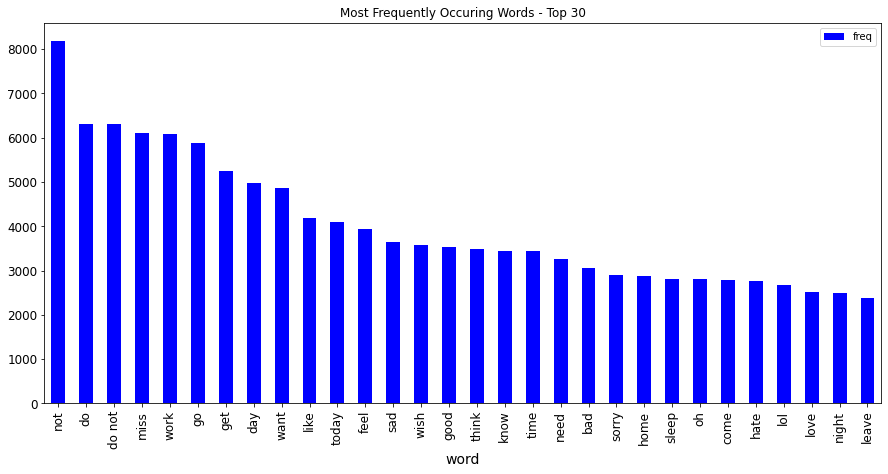

In [ ]:
# most commonly occuring words 
import matplotlib.pyplot as plt
sum_words = X_train.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

### STORE DATASET

In [ ]:
%store X_train
%store X_test
%store y_train
%store y_test

Stored 'X_train' (csr_matrix)
Stored 'X_test' (csr_matrix)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


In [ ]:
pip install modin[ray] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# for parallelization
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()

# models 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten
# from keras.layers import GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer

# Make the notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

# evaluation
from sklearn import metrics

%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

X_train = X_train.toarray()
X_test  = X_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reducing Number of Datapoints for better model training times
X_train = np.resize(X_train, (100000, 1000))
y_train = np.resize(y_train, (100000,))
X_test  = np.resize(X_test, (42000, 1000))
y_test  = np.resize(y_test, (42000,))

# Note: Still stratified 

In [ ]:
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [ ]:
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_train, y_train, train_size=0.2)

In [ ]:
# Implement a simple, single layer LSTM model
model = keras.models.Sequential([
    
    # Embedding layer maps words to dense vectors
    keras.layers.Embedding(1000, 64),
    
    # LSTM layer with 64 units
    keras.layers.LSTM(64),
    
    # Fully connceted layer performs classification on the LSTM output
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Compile the model, specifying optimsier, loss and metrics
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [ ]:
with parallel_backend("ray"):
    model.fit(X_train_valid, y_train_valid, batch_size=10, epochs=3, validation_data=(X_test_valid, y_test_valid))

Epoch 1/3
2000/2000 [==============================] - 1239s 618ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 9.2680e-06 - val_accuracy: 1.0000
Epoch 2/3
2000/2000 [==============================] - 1226s 613ms/step - loss: 4.8438e-06 - accuracy: 1.0000 - val_loss: 2.3514e-06 - val_accuracy: 1.0000
Epoch 3/3
2000/2000 [==============================] - 1223s 611ms/step - loss: 1.4105e-06 - accuracy: 1.0000 - val_loss: 7.8128e-07 - val_accuracy: 1.0000


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 97,089
Trainable params: 97,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr = LogisticRegression()

with parallel_backend("ray"):
    lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)
evaluate(y_test, y_predict, 'Logistic Regression')

In [ ]:
svm = SVC()

with parallel_backend("ray"):
    svm.fit( X_train, y_train)

y_predict = svm.predict(X_test,y_test)
evaluate(y_test, y_predict, 'SVM')